# Outline:
    Import Libraries and datasets from PyTorch Geometric
    1. GIN for node classification task
    2. GIN for graph-level classification task

# Import Libraries

In [1]:
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install torch_geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Dataset

In [66]:
from torch_geometric.datasets import Planetoid
!pip install numpy==1.24.1
# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="cora")

data = dataset[0]


# Print information about the dataset

In [67]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [68]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 0


# Plot dataset

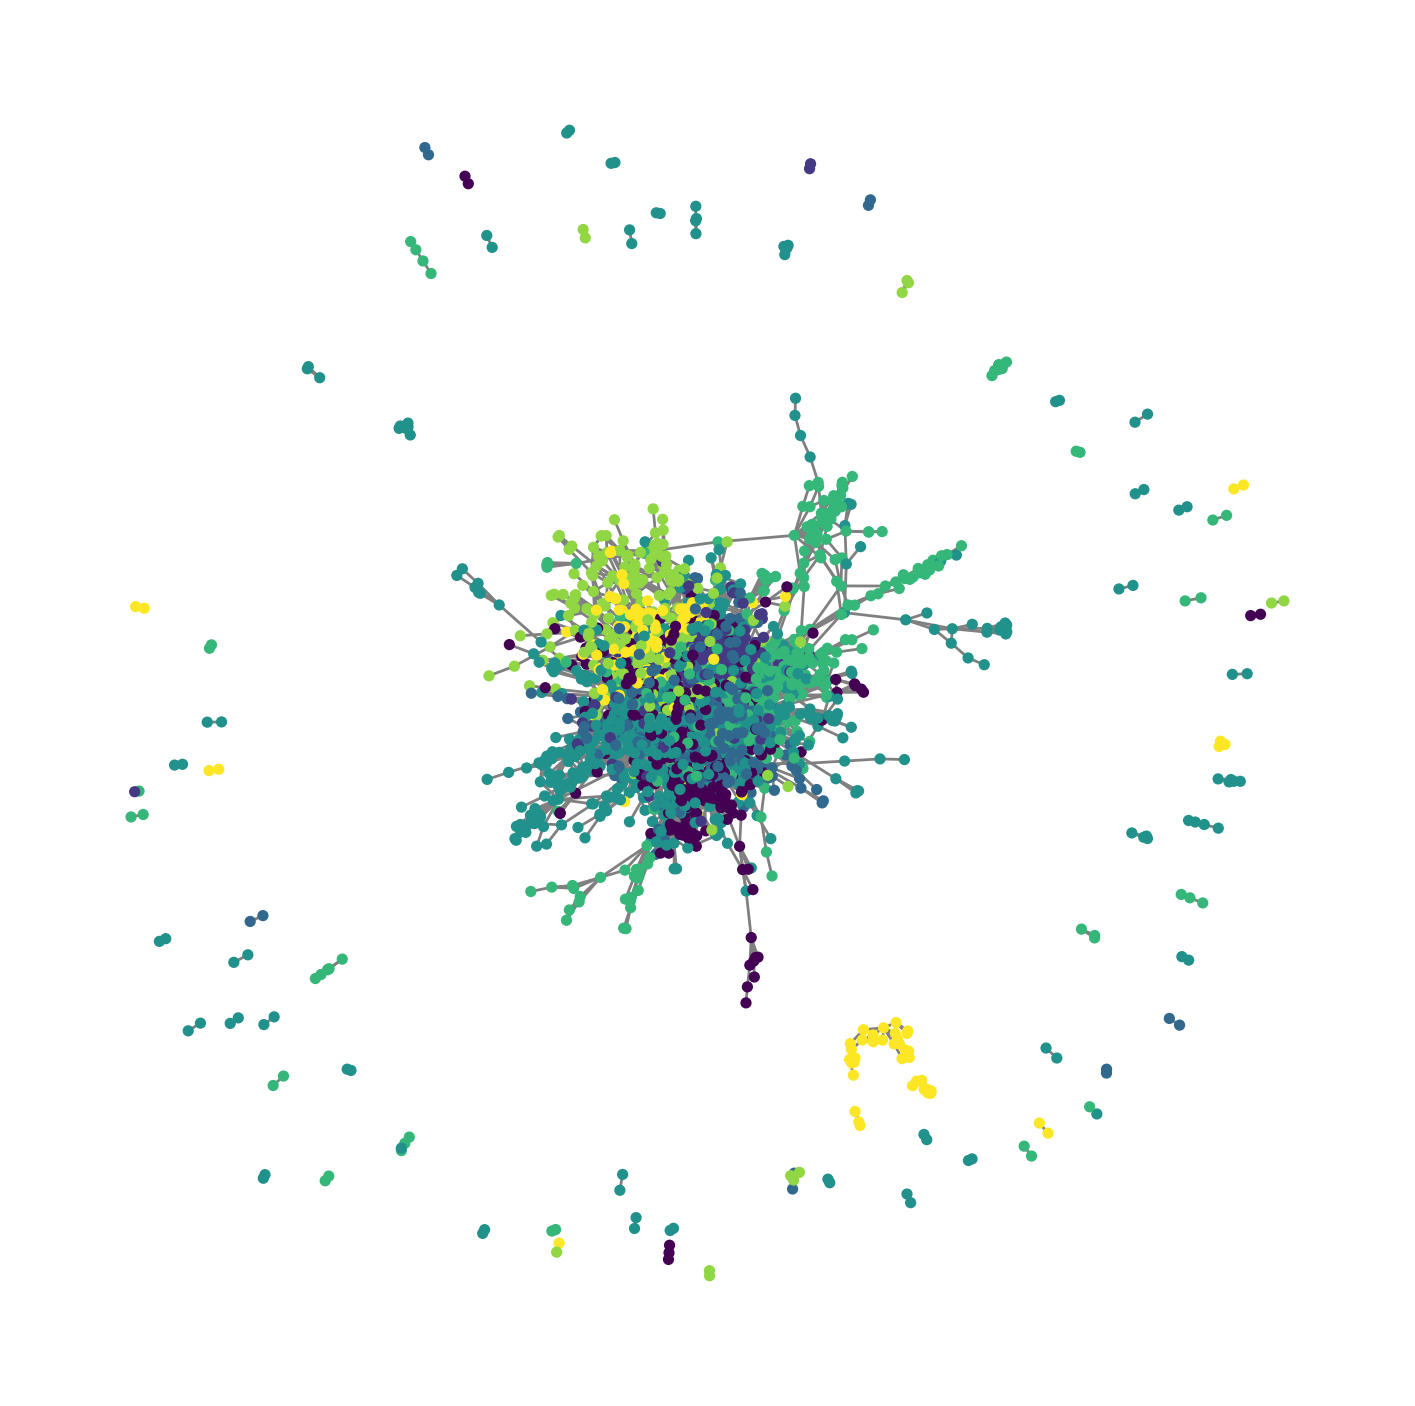

In [69]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

# 1. GIN for node classification task

## 1.1. GIN Conv

In [98]:
import torch
from torch import Tensor
from torch_geometric.nn.conv import MessagePassing

class GINConv(MessagePassing):
    def __init__(self, nn: Callable, eps: float = 0., train_eps: bool = False):
        # Initialize the MessagePassing base class with 'add' aggregation
        super().__init__(aggr='add')
        
        # Neural network for updating node features
        self.nn = nn
        
        # Epsilon value to adjust how much of the current node's feature is kept
        self.eps = torch.nn.Parameter(torch.tensor([eps])) if train_eps else torch.tensor([eps])
    
    def reset_parameters(self):
        # Reset neural network parameters
        self.nn.reset_parameters()
        # Reset epsilon to the initial value
        self.eps.data.fill_(self.eps.item())
    
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # Propagate messages between nodes based on edge connections
        out = self.propagate(edge_index, x=x)
        
        # Update the node features by combining the propagated messages and self-loops
        out = out + (1 + self.eps) * x
        
        # Pass the updated features through the neural network
        return self.nn(out)
    
    def message(self, x_j: Tensor) -> Tensor:
        # Message function: simply pass the features from neighbors
        return x_j

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn})'


## 1.2. GIN

In [93]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, num_features, num_classes, dim=16, drop=0.5):
        super(GIN, self).__init__()
        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, num_classes))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(num_classes)
        self.drop = torch.nn.Dropout(p=0.5)
        
        self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

    def forward(self, x, edge_index):
        x = F.selu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.drop(x)
        x = F.selu(self.conv2(x, edge_index))
        x = self.bn2(x)
        return x, F.softmax(x, dim=1)

In [94]:
%%time

# Create GIN model
gin = GIN(dataset.num_features, 8, dataset.num_classes)
print(gin)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=1433, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=7, bias=True)
  ))
  (bn1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=8, bias=True)
  ))
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
CPU times: user 1.77 ms, sys: 868 µs, total: 2.64 ms
Wall time: 2.3 ms


## 1.3. Train function

In [95]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 5

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

## 1.4. Test function

In [96]:
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [97]:
# Train
train(gin, data)

# Test
acc = test(gin, data)
print(f'\nGIN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 2.109 | Train Acc:   7.14% | Val Loss: 2.11 | Val Acc: 10.00%
Epoch   1 | Train Loss: 2.057 | Train Acc:  18.57% | Val Loss: 2.09 | Val Acc: 12.20%
Epoch   2 | Train Loss: 2.019 | Train Acc:  27.86% | Val Loss: 2.06 | Val Acc: 17.60%
Epoch   3 | Train Loss: 1.951 | Train Acc:  39.29% | Val Loss: 2.04 | Val Acc: 20.60%
Epoch   4 | Train Loss: 1.913 | Train Acc:  45.00% | Val Loss: 2.02 | Val Acc: 27.60%
Epoch   5 | Train Loss: 1.907 | Train Acc:  47.14% | Val Loss: 2.01 | Val Acc: 28.80%

GIN test accuracy: 20.80%



# 2. GIN for Graph classification task

#### Graph Pooling

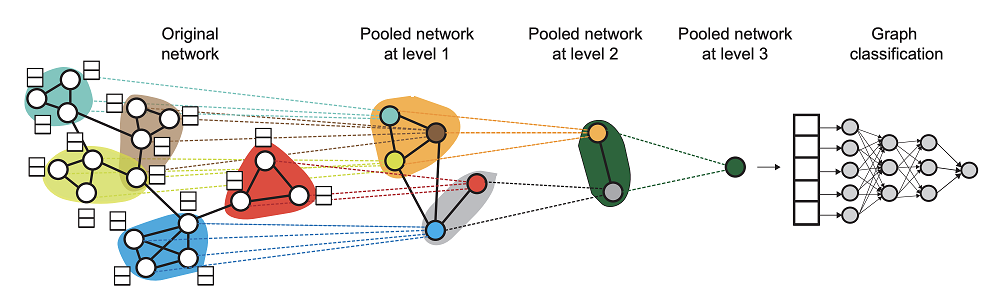

## 2.1. Loading PROTEINS dataset and Print information about the dataset

In [99]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 18
Number of features: 3
Number of classes: 2


## 3D plot

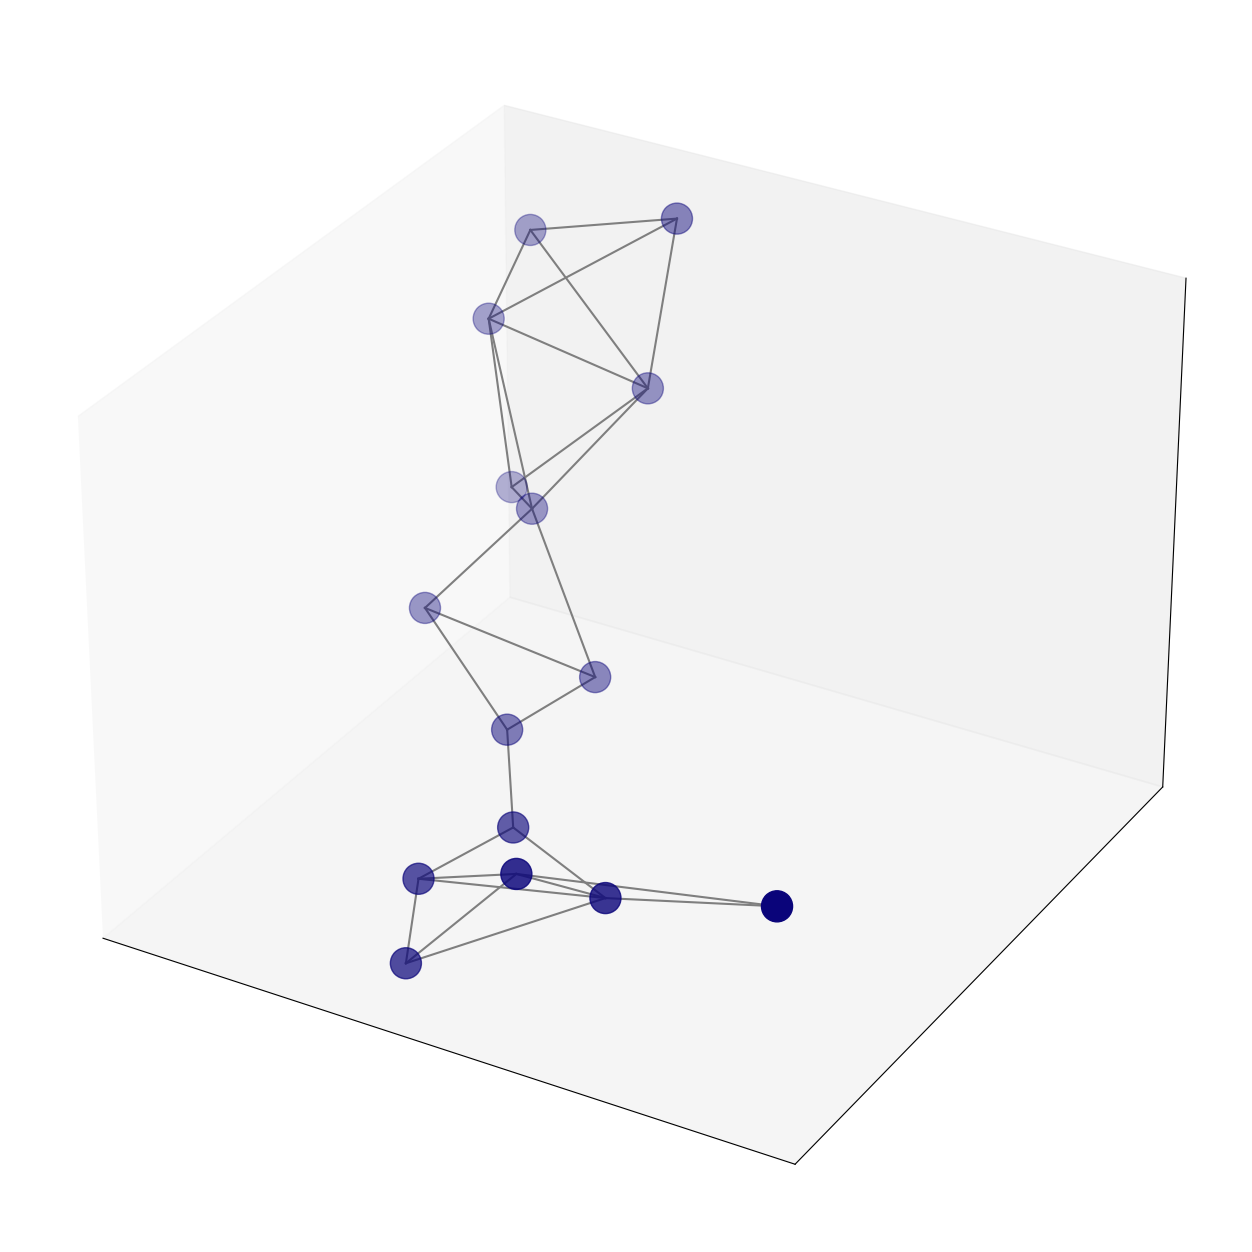

In [100]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

## 2.2. Split train/val/test set

In [14]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 9880], x=[2591, 3], y=[64], batch=[2591], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 8510], x=[2275, 3], y=[64], batch=[2275], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 8800], x=[2284, 3], y=[64], batch=[2284], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 8760], x=[2346, 3], y=[64], batch=[2346], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 8596], x=[2268, 3], y=[64], batch=[2268], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 7572], x=[2048, 3], y=[64], batch=[2048], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 10590], x=[2868, 3], y=[64], batch=[2868], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 11526], x=[3090, 3], y=[64], batch=[3090], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 9182], x=[2449, 3], y=[64], batch=[2449], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 9632], x=[2554, 3], y=[64], bat

## 2.3. GIN model for graph-level classification

In [103]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_add_pool

class GIN(torch.nn.Module):
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

gin = GIN(dim_h=32)

## 2.4. Train & test

In [102]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for data in loader:
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

    # Print metrics every 10 epochs
    if(epoch % 10 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')
          
    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
      _, out = model(data.x, data.edge_index, data.batch)
      loss += criterion(out, data.y) / len(loader)
      acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gin = train(gin, train_loader)

Epoch 100 | Train Loss: 0.52 | Train Acc: 76.97% | Val Loss: 0.48 | Val Acc: 79.49%
Test Loss: 0.53 | Test Acc: 73.70%


## 2.5. Plot graph classification

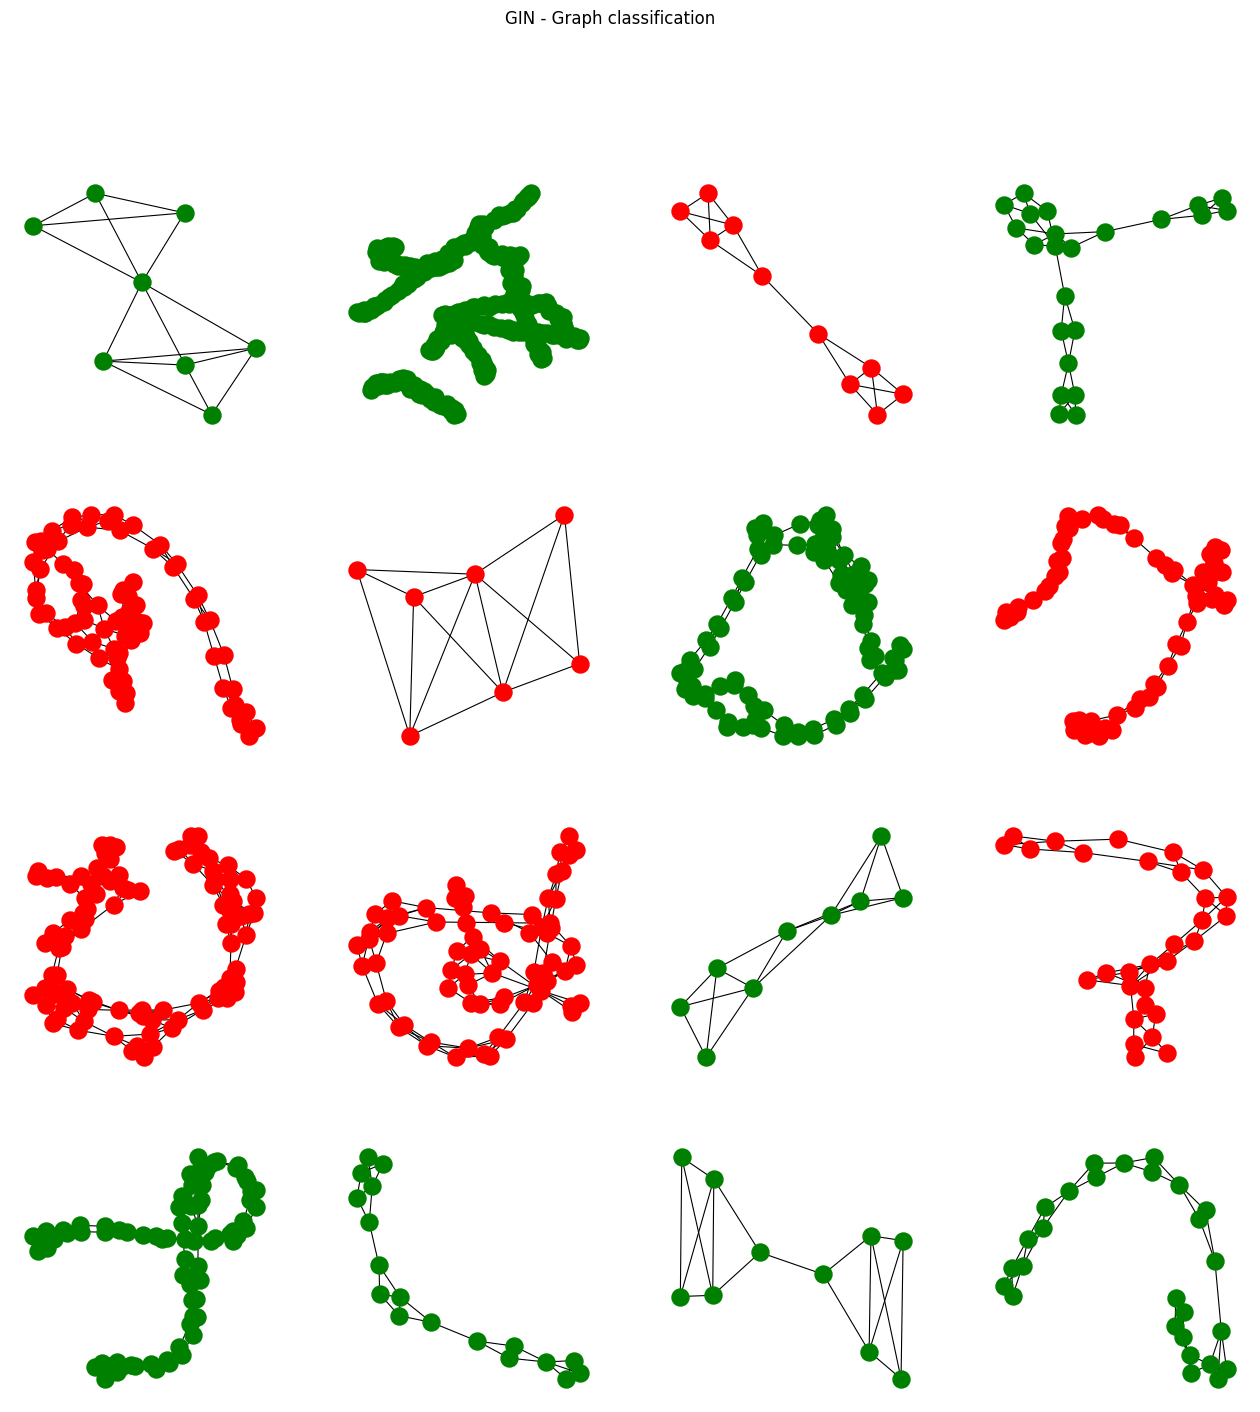

In [17]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )


## 2.6. Ensemble learning

In [18]:
gin.eval()
acc_gin = 0
acc = 0

for data in test_loader:
    # Get classifications
    _, out_gin = gin(data.x, data.edge_index, data.batch)
    out =  out_gin

    # Calculate accuracy scores
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results

print(f'GIN accuracy:     {acc_gin*100:.2f}%')

GIN accuracy:     71.35%
